<a href="https://colab.research.google.com/github/macgyver121/IS_DADS/blob/main/word2vec_data%2BSVM_rdf10r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

# Install Library

In [36]:
pip install pythainlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import pandas as pd
import numpy as np
import re
import emoji

from pythainlp.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from gensim.test.utils import common_texts
from gensim.models import Word2Vec

from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.callbacks import History

import tensorflow as tf

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

from datetime import datetime
from keras import callbacks

import keras.backend as K

# Import file

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# import csv file
df = pd.read_csv('/content/drive/MyDrive/data_all.csv', delimiter=',')

In [42]:
df.loc[:,'text'] = df.loc[:,'text'].map(word_tokenize)

In [43]:
df

,label,text
0,1.0,[1]
1,1.0,[สวัสดี]
2,1.0,"[อรุณสวัสดิ์, , ดู, ข่าว]"
3,1.0,"[D, , jai]"
4,1.0,"[สวัสดี, ชาวโลก]"
...,...,...
11954,1.0,"[จุดแข็ง, หัว, , จุดอ่อน, ที่อยู่]"
11955,1.0,[]
11956,1.0,"[เจอ, ไฟไหม้, , โทร, แจ้ง, , เบอร์]"
11957,0.0,"[แม่, ง, เก่ง]"


# Load Word2Vec(TNCc5model)

In [44]:
# load pretrained model
model = Word2Vec.load("http://www.arts.chula.ac.th/ling/wp-content/uploads/TNCc5model.bin") 

In [45]:
model.wv['ลุง']

array([ 3.070527  ,  0.18736465, -1.5764655 ,  2.241788  ,  0.43824068,
       -0.87465227, -0.7722275 ,  1.9654195 , -0.43167496, -1.4505666 ,
        1.3940482 ,  0.4560658 ,  0.45843145, -0.07568713, -0.75192523,
       -1.356236  , -1.0442775 ,  1.0418516 , -0.70091647,  2.8195927 ,
        0.8817045 ,  1.0285571 ,  1.2320664 , -1.67092   , -1.0690225 ,
        2.4106567 ,  1.292201  , -1.3555707 ,  0.60082823, -0.11551253,
        0.07939093,  0.5320371 ,  3.4767208 , -1.0047841 , -1.3386122 ,
       -1.7414153 , -0.6018563 , -3.094479  ,  1.7858883 , -0.2012835 ,
        0.9770544 ,  0.43677285,  2.5374718 , -0.08855058,  1.4834609 ,
        1.3691067 , -0.03194451,  0.72896075,  1.0513773 , -0.6755366 ,
        0.8462946 ,  1.7215761 , -0.70261467,  0.04218017,  1.1874788 ,
        1.49271   , -0.7328836 ,  0.6872654 , -0.15794674, -0.6182871 ,
       -0.64685875, -1.7562376 , -0.52613497, -0.546221  ,  1.0374576 ,
        1.8402972 ,  2.6733527 , -1.3647726 ,  2.7549903 , -3.39

# Create X

In [46]:
sent = [row for row in df['text']]

In [47]:
X = []
for sentence in sent:
    vec = np.zeros(100)
    count = 0
    for word in sentence:
        try:
            vec += model.wv[word]
            count += 1
        except:
            pass
    vec = vec / count
    X.append(vec)

<ipython-input-47-518b6334eb40>:11: RuntimeWarning: invalid value encountered in true_divide
  vec = vec / count


In [48]:
X = np.nan_to_num(X, nan=0)

print(X[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [49]:
# create y
y = df['label']
y.shape

(11959,)

# Spliting Data

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Apply SMOTE to the training data
smote = SMOTE()
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

In [52]:
print('Train Set ->', X_train_oversampled.shape, y_train_oversampled.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (18132, 100) (18132,)
Test Set -> (2392, 100) (2392,)


# Train Model

In [53]:
import gensim
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn import metrics

In [54]:
start_time = datetime.now()

svm = SVC(kernel='rbf', C=10)
svm.fit(X_train_oversampled, y_train_oversampled)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:45.592860


In [55]:
y_pred = svm.predict(X_test)

In [56]:
def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [57]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print('Accuracy:', accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score(precision, recall))

Accuracy: 0.657190635451505
Precision: 0.657573292412842
Recall: 0.657190635451505
F1-score: 0.6573818582467665


In [58]:
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.471     0.451     0.461       266
         1.0      0.748     0.745     0.747      1477
         2.0      0.528     0.542     0.535       649

    accuracy                          0.657      2392
   macro avg      0.582     0.579     0.581      2392
weighted avg      0.658     0.657     0.657      2392



using the precision_score or recall_score functions from scikit-learn with the average='binary' parameter, but the target variable has more than two classes. To fix this, you can use one of the other available average options:

- average=None: Returns the precision or recall for each class separately.
- average='micro': Calculates the precision or recall globally by counting the total true positives, false negatives, and false positives across all classes.
- average='macro': Calculates the precision or recall for each class separately and then takes the unweighted mean across all classes.
- average='weighted': Calculates the precision or recall for each class separately and then takes the weighted mean across all classes, weighted by the number of samples in each class.

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 120  107   39]
 [ 101 1100  276]
 [  34  263  352]]


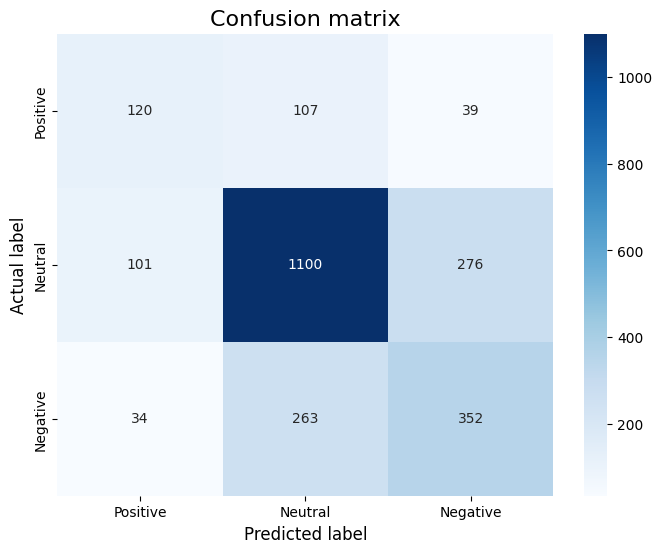

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(svm, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Positive', 'Neutral', 'Negative']
    # use model to do the prediction
    y_pred = svm.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('Actual label', fontsize=12)
    
plot_confusion_matrix(svm, X_test, y_test)

In [61]:
input = ['ดีครับ', 'ลุงตู่', 'คคคคค', 'สวัสดีวันจันทร์', 'เยี่ยมไปเลย', 'สู้ๆครับ', 'แย่มาก', 'ไม่โอเค', 'อย่างห่วย']

In [62]:
X_new = []
for sentence in input:
    vec = np.zeros(100)
    count = 0
    for word in sentence:
        try:
            vec += model.wv[word]
            count += 1
        except:
            pass
    vec = vec / count
    X_new.append(vec)
X_new = np.nan_to_num(X_new, nan=0)
y_new = svm.predict(X_new)
print(y_new)

[1. 1. 2. 1. 1. 1. 1. 1. 1.]
